In [1]:
import numpy as np
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/texture-tactip/"


def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

def darken_color(color, factor):
    rgb = mcolors.to_rgb(color)
    return tuple([factor * x for x in rgb])



/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## load data

In [2]:
import xml.etree.ElementTree as ET

def gather_reading_tags(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # List to hold arrays of <Reading> tags when interrupted by outer structures
    all_reading_arrays = []
    current_readings = []

    # Recursive function to traverse the XML tree
    def traverse_tree(element):
        nonlocal current_readings
        
        # If we encounter a <Reading> tag, gather its attributes
        if element.tag == "Reading":
            # Get the 'Time' attribute, or any other attributes if needed
            time_value = element.attrib.get("Time", None)
            if time_value:
                current_readings.append(float(time_value))
        elif element.tag == "Trial":
            # If we encounter a non-Reading tag and current_readings is non-empty,
            # it means the <Reading> structure has been interrupted.
            if current_readings:
                all_reading_arrays.append(current_readings)
                current_readings = []  # Start a new array for the next set

        # Recursively traverse children elements
        for child in element:
            traverse_tree(child)
        
        # After traversing all children, check again if readings exist for outer structures
        if current_readings and element == root:
            all_reading_arrays.append(current_readings)
            current_readings = []

    # Start traversing from the root
    traverse_tree(root)

    # Output the gathered arrays of Reading tags
    return all_reading_arrays

# Specify your XML file path here
xml_file_path = datapath.replace("datasets","stuff")+'/TacTip_Cork_nomarker_P20/TacTip_Wool_nomarker_P20.xml'

# Gather and print the Reading tags arrays
reading_arrays = gather_reading_tags(xml_file_path)

ar=np.array(reading_arrays) #
print(ar.shape)
print(np.average(np.diff(ar,axis=1)), np.average(np.max(ar,axis=1)-np.min(ar,axis=1))/ar.shape[1])

print(np.average(np.max(ar,axis=1)-np.min(ar,axis=1)), (np.average(np.max(ar,axis=1)-np.min(ar,axis=1))*ar.shape[0])/60)


(200, 100)
0.10001833460547707 0.0990181512594223
9.90181512594223 33.00605041980744


### electrical

In [3]:
data_ = np.load(datapath+"X_data_presstip_freq.npz") #load data
X=None
for array_name in data_:
    X=data_[array_name]
X=(X* 3.3) / 65536 #convert to voltage
data_ = np.load(datapath+"y_data_presstip_freq.npz") #load data
y=None
for array_name in data_:
    y=data_[array_name]

cutoff_frequency = 3.3  # Define your cutoff frequency
sampling_rate = 50.0    # Define your sampling rate
filter_order = 5       # Order of the filter

# Assuming dataset is of shape (n, t, s)
def apply_filter_to_dataset(dataset, cutoff, fs, order=5):
    n, t, s = dataset.shape
    filtered_data = np.zeros_like(dataset)

    # Apply the filter to each sensor for each item
    for i in range(n):
        for j in range(s):
            filtered_data[i, :, j] = butter_lowpass_filter(dataset[i, :, j], cutoff, fs, order)

    return filtered_data

# Example usage
# dataset = np.random.randn(n, t, s)  # Example dataset (replace with your actual data)
filtered_dataset = apply_filter_to_dataset(X, cutoff_frequency, sampling_rate, filter_order)
#X=filtered_dataset
X=X[:,0:30]
print(X.shape,y.shape)

(400, 30, 16) (400,)


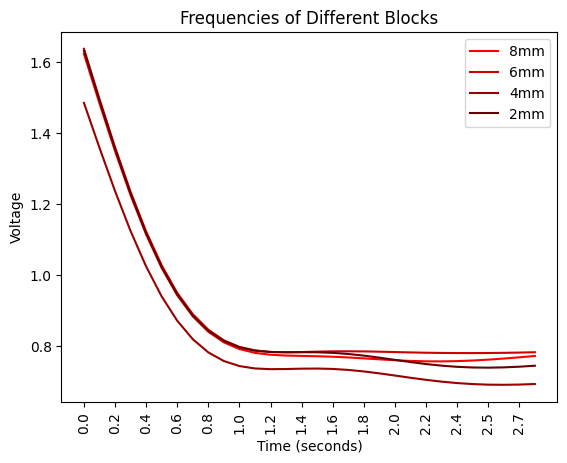

In [100]:
# Define base blue color
base_blue = "red"

# Different darkness levels for each line
darkness_levels = [1.0, 0.8, 0.6, 0.4]  # Higher values mean lighter


mil8=X[np.where(y==1)]
mil6=X[np.where(y==2)]
mil4=X[np.where(y==3)]
mil2=X[np.where(y==0)]
plus=0
plt.plot(np.average(mil8[:,:,8+plus],axis=0),c=darken_color(base_blue, darkness_levels[0]),label="8mm")
#plt.plot(np.average(mil8[:,:,8+plus],axis=0)+np.std(X[:,:,8],axis=0),"--",c=darken_color(base_blue, darkness_levels[0]))

plt.plot(np.average(mil6[:,:,8+plus],axis=0),c=darken_color(base_blue, darkness_levels[1]),label="6mm")
#plt.plot(np.average(mil6[:,:,8+plus],axis=0)+np.std(X[:,:,8],axis=0),"--",c=darken_color(base_blue, darkness_levels[1]))

plt.plot(np.average(mil4[:,:,8+plus],axis=0),c=darken_color(base_blue, darkness_levels[2]),label="4mm")
#plt.plot(np.average(mil4[:,:,8+plus],axis=0)+np.std(X[:,:,8],axis=0),"--",c=darken_color(base_blue, darkness_levels[2]))

plt.plot(np.average(mil2[:,:,8+plus],axis=0),c=darken_color(base_blue, darkness_levels[3]),label="2mm")
#plt.plot(np.average(mil2[:,:,8+plus],axis=0)+np.std(X[:,:,8],axis=0),"--",c=darken_color(base_blue, darkness_levels[3]))
plt.title("Frequencies of Different Blocks")
plt.legend(loc="upper right")
plt.ylabel("Voltage")
plt.xlabel("Time (seconds)")
plt.xticks([i for i in range(0,len(np.average(mil2[:,:,8],axis=0)),2)],[round(i*0.098,1) for i in range(0,len(np.average(mil2[:,:,8],axis=0)),2)],rotation=90)
plt.show()

## classification 

In [15]:
train_X, test_X, train_y, test_y = train_test_split(X[:,0:9,8:12].reshape(len(X),-1), y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(max_depth=50, random_state=0)
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
y_pred2 = clf.predict(train_X)

loss=np.abs(y_pred-test_y)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Test Accuracy:",correct/len(loss))

loss=np.abs(y_pred2-train_y)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Train Accuracy:",correct/len(loss))

np.save(path+"/data/RFC_P_x.npy",y_pred)
np.save(path+"/data/RFC_P_y.npy",test_y)

Test Accuracy: 1.0
Train Accuracy: 1.0
